In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import cv2 as cv
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

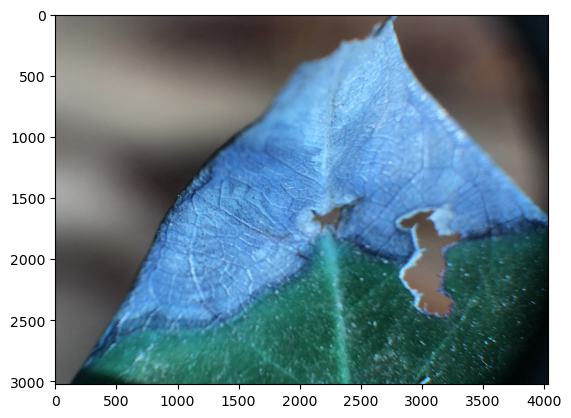

In [2]:
DATADIR = #directory of datasets

CATEGORIES = ["Dehydration", "Thrips"]

# Load and display an image from each category
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv.imread(os.path.join(path, img))
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break  # Display only one image from each category
    break  # Display images from only one category

In [3]:
# Create training data
training_data = []
IMG_SIZE = 224

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_detect = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv.imread(os.path.join(path, img))
                resized_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([resized_array, class_detect])
            except Exception as e:
                pass

create_training_data()

In [4]:
# Randomly shuffle the training data
random.shuffle(training_data)

In [5]:
X = []
y = []

# Create features and labels
for features, labels in training_data:
    X.append(features)
    y.append(labels)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

print(X.shape, y.shape)  # Verify the shapes

(301, 224, 224, 3) (301,)


In [6]:
# Normalize pixel values to the range [0, 1]
X = X / 255.0

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images by up to 20 degrees
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True  # Flip images vertically
)

# Create augmented data
augmented_data = []

for i in range(len(X)):
    img = X[i]
    label = y[i]
    img = np.expand_dims(img, axis=0)
    augmented_images = datagen.flow(img, batch_size=1)
    
    for j in range(5):  # You can adjust the number of augmented images per original image
        augmented_image = augmented_images.next()[0].astype('uint8')
        augmented_data.append([augmented_image, label])

# Append augmented data to original data
X_augmented = np.array([item[0] for item in augmented_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_augmented = np.array([item[1] for item in augmented_data])

# Combine original and augmented data
X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)

print(X_combined.shape, y_combined.shape)  # Verify the shapes

(1806, 224, 224, 3) (1806,)


In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [16]:
# Define input shape
input_shape = (224, 224, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Flatten layer
x = Flatten()(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Output layer
outputs = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Use Adam optimizer with a specific learning rate
optimizer = Adam(learning_rate=1e-6)  # Adjust the learning rate as needed

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Making early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Adjust patience as needed

In [12]:
# model.summary()

In [17]:
# Train the model
model.fit(X_combined, y_combined, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Lists to store accuracy and loss
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

# Training the model with tracking accuracy and loss
for epoch in range(50):  # Adjust the number of epochs as needed
    history = model.fit(X_combined, y_combined, epochs=1, validation_split=0.2)
    
    # Append accuracy and loss to lists
    train_acc_list.append(history.history['accuracy'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_accuracy'])
    val_loss_list.append(history.history['val_loss'])

# Save the model if needed
# model.save("your_model.h5")

# Now, you can use the lists to visualize the training progress
# Plot training and validation accuracy
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/50
46/46 [==============================] - 32s 685ms/step - loss: 0.6951 - accuracy: 0.5145 - val_loss: 0.6925 - val_accuracy: 0.6050
Epoch 2/50
46/46 [==============================] - 30s 643ms/step - loss: 0.6912 - accuracy: 0.5353 - val_loss: 0.6924 - val_accuracy: 0.6105
Epoch 3/50
46/46 [==============================] - 29s 642ms/step - loss: 0.6964 - accuracy: 0.5429 - val_loss: 0.6922 - val_accuracy: 0.6298
Epoch 4/50
46/46 [==============================] - 30s 643ms/step - loss: 0.6907 - accuracy: 0.5533 - val_loss: 0.6921 - val_accuracy: 0.6436
Epoch 5/50
46/46 [==============================] - 30s 645ms/step - loss: 0.6907 - accuracy: 0.5526 - val_loss: 0.6920 - val_accuracy: 0.6519
Epoch 6/50
46/46 [==============================] - 29s 637ms/step - loss: 0.6879 - accuracy: 0.5713 - val_loss: 0.6919 - val_accuracy: 0.6436
Epoch 7/50
46/46 [==============================] - 30s 648ms/step - loss: 0.6834 - accuracy: 0.5706 - val_loss: 0.6918 - val_accuracy: 0.6409

KeyboardInterrupt: 